# Using the `nlputils` library
In this iPython Notebook are some examples of how various parts of the `nlputils` library can be used with text and other datasets. General knowledge of common machine learning algorithms and NLP is assumed.

We will show how to transform a text corpus into tf-idf features and classify the documents with standard sklearn classifiers as well as the knn classifier part of this library. Additionally, the corpus will be visualized in two dimensions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import fetch_20newsgroups, load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression as logreg
import sklearn.metrics as skmet
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA

# transform documents into tf-idf features
from nlputils.features import FeatureTransform, features2mat
# compute similarity matrices
from nlputils.simmat import compute_K_map, compute_K, dist2kernel
# classify with knn classifier
from nlputils.knn_classifier import knn, get_labels
# embed in 2D and plot
from nlputils.embedding import proj2d, tsne_sim, classical_scaling
from nlputils.visualize import basic_viz, get_colors

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Analyzing a Text Corpus
In this section, we explain how to transform text documents into feature vectors and how these vectors can be used to classify the documents as well as visualize the corpus in 2D.

### Transforming text into features
This first part shows how to use the `FeatureTransform` class and the `features2mat` function from `nlputils.features` to transform text documents into [tf-idf features](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).
#### The 20 newsgroups dataset
The first step is to get some data we can work with. For this we use the [20 newsgroups text corpus](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html).
We subsample 7 of the 20 categories and remove meta information such as headers to avoid overfitting.

In [2]:
# load the data
categories = [
    "comp.graphics",
    "rec.autos",
    "rec.sport.baseball",
    "sci.med",
    "sci.space",
    "soc.religion.christian",
    "talk.politics.guns"
]
newsgroups_train = fetch_20newsgroups(subset='train', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=(
    'headers', 'footers', 'quotes'), data_home='data', categories=categories, random_state=42)

The text documents have to be stored in a dictionary, where each document has an id mapping to its text. The corresponding categories of the documents are saved in a dictionary as well. Additionally, we create a mapping from the category number to its description.

In [3]:
# create a dictionary mapping a document id to its text
textdict = {i: t for i, t in enumerate(newsgroups_train.data)}
textdict.update({i: t for i, t in enumerate(newsgroups_test.data, len(newsgroups_train.data))})
# similarly map the document ids to their category labels
doccats = {i: c for i, c in enumerate(newsgroups_train.target)}
doccats.update({i: c for i, c in enumerate(newsgroups_test.target, len(newsgroups_train.target))})
# remember which ids map to training and test data
train_ids = range(len(newsgroups_train.data))
test_ids = range(len(newsgroups_train.data), len(textdict))
# and create a mapping from the category ids to their descriptions
catdesc = {i: d for i, d in enumerate(newsgroups_train.target_names)}
print "%i training and %i test samples" % (len(train_ids), len(test_ids))

4107 training and 2734 test samples


#### Generating tf-idf features
Now that we have the data in the format expected by the library, we can transform the texts into [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) feature vectors. For this we use the `FeatureTransform` class from `nlputils.features`.

The feature extraction process is summarized in the figure below:
<img src="feature_extraction.png" width="600">
In a first step, the texts are **preprocessed**, for which we can choose whether to transform the texts to lowercase (by default `to_lower=True`) and whether to normalize numbers (i.e. replace all digits with '1's, which still allows you to distinguish e.g. dates from phone numbers but otherwise creates more overlap between the texts since you can assume the exact phone number doesn't matter; again by default `norm_num=True`). 

Additionally, we can **identify bigrams** in the texts and treat them as single units instead of splitting these words up later when counting the term frequencies. Instead of just taking all combinations of two words occurring in the texts, thereby vastly increasing the dimensionality of the feature space, for each bigram a score is computed depending on how often the two words occur together in this combination and only relevant bigrams are included as features (by default `identify_bigrams=True`).

The next step is the actual transformation of the texts into tf-idf features. First, the **term frequencies** of each text are counted; these counts can be **normalized** with the `norm` option: basically the choice here is whether to only use binary features (`norm='binary'`) or the actual term frequencies (e.g. with `norm='max'`). Then, the term frequencies can be **weighted** by their idf scores (by default `weight=True`). As a last step, the weighted counts can be **renormalized**, e.g. by dividing them by the maximum value or the length of the vector (by default `renorm='length'`). All possible combinations of normalization, weighting, and renormalization are illustrated below:
<img src="feature_normalization.png" width="600">

While the feature extraction process does not make use of any category labels, it is still advised to avoid possible overfitting by only using the training documents for identifying relevant bigrams and computing the idf weights. This can be done by passing the ids of the training documents as `fit_ids` when transforming the texts into features.

The result of the feature extraction process is a dictionary with the document ids as keys and then for every text a dictionary mapping the words occurring in it to the (weighted, normalized) counts. (Note: these feature dictionaries are sparse, i.e. only contain the tf-idf features for words actually occurring in the document).

In [4]:
# transform into tf-idf features
ft = FeatureTransform(norm='max', weight=True, renorm='max')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)

The initialized `FeatureTransform` instance can also be applied to other text dictionaries later on (e.g. if more test examples become available). The first time `texts2features` is called, the idf weights are computed and a list with acceptable bigrams is generated (possibly based on only the documents listed in the `fit_ids`). These are then used when computing the document features in successive calls to the function.

To use the tf-idf features e.g. with sklearn classifiers, they should be arranged in a feature matrix instead of in dictionaries. To do this, `nlputils.features` provides the `features2mat` function. It returns a sparse (csr) matrix, where each row represents a document and in the columns are the counts of the individual words. The function should first be applied to the training data, then the returned featurenames (a list indicating which word is represented in which column) should be included when computing the matrix for the test data to ensure the feature dimensions of training and test data are the same.

In [5]:
# save in matrix form
X, featurenames = features2mat(docfeats, train_ids)
X_test, _ = features2mat(docfeats, test_ids, featurenames)
print "%i features" % len(featurenames)

45819 features


### Classifying with sklearn (Linear SVM and Logistic Regression)
Let's see how these features work with sklearn to solve the classification problem. We'll try logistic regression and a linear SVM with the feature matrices we have just generated for the corpus.

In [6]:
# transform the labels in the doccats dictionary back to vectors required by sklearn
y_train = [doccats[tid] for tid in train_ids]
y_test = [doccats[tid] for tid in test_ids]
# train the logistic regression classifier
clf = logreg(class_weight='balanced', random_state=1)
clf.fit(X, y_train)
# predict the labels of the test set
y_pred = list(clf.predict(X_test))
# report the F1 score
print "F1-score: %.5f" % skmet.f1_score(y_test, y_pred, average='micro')

F1-score: 0.84565


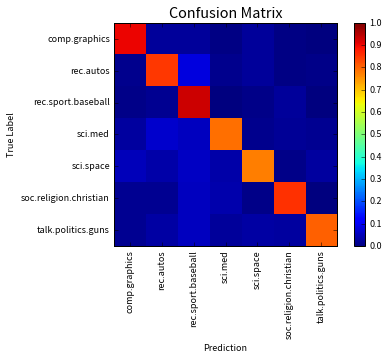

In [7]:
# plot the confusion matrix to get more insights into the classifier mistakes
labels = sorted(catdesc.keys())
confmat = np.array(skmet.confusion_matrix(y_test, y_pred, labels), dtype=float)
# normalize by # true labels
confmat /= np.tile(np.array([np.sum(confmat, axis=1)]).T, (1, confmat.shape[1]))
plt.figure()
plt.imshow(confmat, interpolation='nearest')
plt.xticks(range(len(labels)), [catdesc[i] for i in labels], rotation=90)
plt.yticks(range(len(labels)), [catdesc[i] for i in labels])
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.title("Confusion Matrix", fontsize=16)
plt.clim([0, 1])
plt.colorbar()

The results with logistic regression look pretty good already. What about linear SVM?

In [8]:
# train the linear SVM
clf = LinearSVC(class_weight='balanced', random_state=1)
clf.fit(X, y_train)
# predict the labels of the test set
y_pred = list(clf.predict(X_test))
# report the F1 score
print "F1-score: %.5f" % skmet.f1_score(y_test, y_pred, average='micro')

F1-score: 0.83102


Ok, that's slightly worse than with logistic regression. Of course the classifiers themselves have many hyperparameters which can be tuned to get better results. Instead we'll recompute the features and renormalize them with the vector length. SVM relies on the kernel computation, which in this case is the scalar product of the feature vectors. When these vectors are normalized by their length, this product is the cosine similarity of the documents, a popular similarity measure often used in information retrieval settings.

In [9]:
# recompute features
ft = FeatureTransform(norm='max', weight=True, renorm='length')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
X, featurenames = features2mat(docfeats, train_ids)
X_test, _ = features2mat(docfeats, test_ids, featurenames)
# train SVM and predict
clf = LinearSVC(class_weight='balanced', random_state=1)
clf.fit(X, y_train)
y_pred = list(clf.predict(X_test))
print "F1-score: %.5f" % skmet.f1_score(y_test, y_pred, average='micro')

F1-score: 0.85808


Indeed, now we're better than with logistic regression! What if we use the same features with the LogReg classifier?

In [10]:
clf = logreg(class_weight='balanced', random_state=1)
clf.fit(X, y_train)
y_pred = list(clf.predict(X_test))
print "F1-score: %.5f" % skmet.f1_score(y_test, y_pred, average='micro')

F1-score: 0.83797


For logistic regression the results are worse with these features. 

**Always try different parameter settings when computing the tf-idf features** and remember that what constitutes **optimal features can vary for different classifiers!** It's generally recommended to use idf weighting, however it can make a difference if you use binary or count features (`norm='binary' or 'max'`) and always experiment at least with the `'length'` and `'max'` renormalization.

### Classifying with k-nearest neighbors (knn)
`nlputils.knn_classifier` contains an adaptive weighted k-nearest neighbor implementation based on \[1\], which can be used to classify the documents as well. The knn classifier is directly applied to a similarity matrix with similarity scores for every new test document to all existing training documents (for which we know the labels). This means there is no training of the classifier involved (it is a [lazy learning](https://en.wikipedia.org/wiki/Lazy_learning) algorithm), we simply pick the label of a new document based on the most common label of the training documents most similar to it.

The pairwise similarities of the documents can be computed with functions from `nlputils.simmat`, which generate a similarity matrix using one of the similarity functions defined in `nlputils.simcoefs`. Please note that for some of the similarity functions (e.g. linear kernel) it is possible to compute the whole similarity matrix efficiently with matrix products while for others all entries of the matrix have to be computed individually based on the feature dictionaries, which can increase the computing time dramatically for large datasets (it scales roughly $O(n^2)$).


\[1\] Baoli, Li, Lu Qin, and Yu Shiwen. "An adaptive k-nearest neighbor text categorization strategy." *ACM Transactions on Asian Language Information Processing (TALIP)* 3.4 (2004): 215-226.

In [11]:
# transform texts into features
ft = FeatureTransform(norm='max', weight=True, renorm='length')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# compute the similarity matrix between training and test documents (the kernel map).
#    For this we use the linear kernel, which, since we have length normalized
#    feature vectors, is the cosine similarity between the documents.
#    shape: len(test_ids) x len(train_ids)
K_map = compute_K_map(train_ids, test_ids, docfeats, sim='linear')
# restructure the doccats dictionary to contain a list of (single) categories
#    The knn classifier is set up to be able to select multiple plausible categories
#    per document (or none if it's too unsure about any of them), for this, the labels
#    need to be arranged in lists.
doccats_knn = {tid:[c] for tid, c in doccats.items()}
# apply knn to get a score for every document and category, indicating how likely it 
# is that this document belongs to this category.
#    Different parameter settings might again yield better results.
likely_cat = knn(K_map, train_ids, test_ids, doccats_knn, k=15, adapt=True, alpha=5, weight=True)
# transform the category scores into actual labels for each document
#    For this we can directly give the scores to the get_labels function. 
#    With the threshold set to 'max', only the most likely label is chosen,
#    otherwise all categories scoring above the threshold (or none if
#    scores for all categories for this document are too low) are chosen. 
#    Using a high threshold instead of 'max' might be helpful if the
#    label should only be assigned automatically when the classifier is
#    very sure about its decision and otherwise a human could be consulted.
labels = get_labels(likely_cat, threshold='max')
# transform the returned labels dict into a vector and compute the F1 score
y_pred = [labels[tid][0] for tid in test_ids]
print "F1-score: %.5f" % skmet.f1_score(y_test, y_pred, average='micro')

F1-score: 0.80102


As knn classification is a very simple and straightforward approach, it might not come as a surprise that the results are worse than with SVM or LogReg. But of course again different parameter settings (especially concerning the type of similarity computed between the documents) should be explored. Note that the knn classification itself is pretty fast, it's the computation of the similarity matrix which can take a while. But once the matrix is available, you can easily tune the hyperparameters of the classifier as there is no retraining necessary. And of course, as we will show later, this classifier can be applied to more than just text data, all it needs is a similarity matrix to pick the most likely categories, but this similarity matrix does not necessarily have to be computed with the corresponding `nlputils.simmat` function.

### Visualizing the Corpus in 2D
To get an overview of a dataset, it is often helpful to plot it. Since we're dealing with a very high dimensional feature space here, a dimensionality reduction method has to be applied to embed the data in two dimensions. We'll show example visualizations created with the classical scaling (kPCA) and t-SNE implementations found in `nlputils.embedding`.

Both embedding methods take as input a precomputed similarity matrix, which can again be computed with `nlputils.simmat`. We simply use the linear similarity between the documents here, but other similarity coefficients are worth exploring.

To create the actual plot of the embedding, we use a function from `nlputils.visualize`.

#### Classical Scaling

performing classical scaling: 4107 datapoints


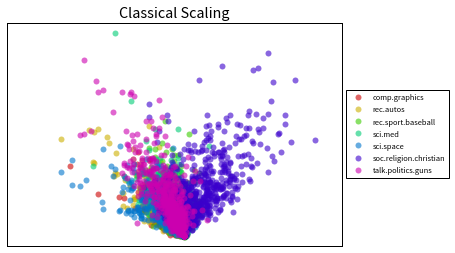

In [12]:
# transform texts into features
ft = FeatureTransform(norm='max', weight=True, renorm='max')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# compute linear similarity matrix of the training data
K = compute_K(train_ids, docfeats, 'linear')
# compute embedding (by default, the proj2d wrapper function computes the
# t-SNE embedding; force it to fall back to classical scaling instead)
x, y = proj2d(K, use_tsne=False)
# use the obtained coordinates to create the plot
# (don't forget to pass the same ids as used for computing K so the x and y
# values can be associated with the right category labels for coloring)
basic_viz(train_ids, doccats, x, y, catdesc, 'Classical Scaling')

While classical scaling/kPCA works well as a general dimensionality reduction method (if you want to reduce the dimensions from a few thousand to, say, 50, while retaining most of the data's variance), it doesn't really create very pretty two dimensional plots. So lets try t-SNE instead.

#### t-SNE
To embed the dataset with t-SNE, we have to compute a pairwise distance matrix of the data and then transform into a special similarity matrix based on a certain perplexity value (roughly how many nearest neighbors a point is assumed to have), as described in the original paper \[2\].

For the text dataset, we first compute the [angular distance](https://en.wikipedia.org/wiki/Cosine_similarity#Angular_distance_and_similarity) matrix of the dataset, and then transform it into a similarity matrix with the `dist2kernel` function from `nlputils.simmat`.

[2] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." *Journal of Machine Learning Research* 9.Nov (2008): 2579-2605.

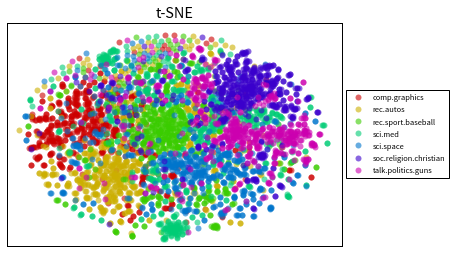

In [13]:
# transform texts into features
ft = FeatureTransform(norm='max', weight=True, renorm='length')
docfeats = ft.texts2features(textdict, fit_ids=train_ids)
# compute angular distance matrix of the training data
K = compute_K(train_ids, docfeats, 'angulardist')
# and transform it into a similarity matrix
K = dist2kernel(K, 30)
# compute embedding and plot
x, y = proj2d(K, use_tsne=True, verbose=False)
basic_viz(train_ids, doccats, x, y, catdesc, 't-SNE')

This looks more interesting than the classical scaling embedding and documents belonging to the same category are forming clusters.

However, note that we've here used the angular distance, not the euclidean distance which t-SNE uses by default. The angular distance is related to the cosine similarity and works well for the sparse text features. Just for comparison, below is the default t-SNE embedding based on the euclidean distances created with the sklearn implementation. There are no meaningful category clusters visible anymore.

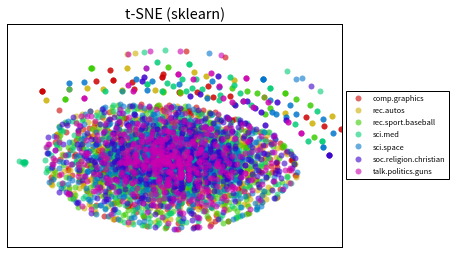

In [14]:
# transform features into matrix
X, _ = features2mat(docfeats, train_ids)
# use t-SNE from sklearn
e_tsne = TSNE(n_components=2, random_state=1, method='exact', perplexity=30)
X_embed = e_tsne.fit_transform(X)
basic_viz(train_ids, doccats, X_embed[:,0], X_embed[:,1], catdesc, 't-SNE (sklearn)')

## Using the `nlputils` library with other kinds of data
While nlputils was devised with text data in mind, many of its functions can be applied to other kinds of data as well. For the following examples we use a [dataset with images of handwritten digits](http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html), first visualize it in 2D and then classify it again with sklearn classifiers as well as knn.

In [15]:
# load digits dataset
digits = load_digits()
X = digits.data
X /= float(X.max())
y = digits.target
n_samples, n_features = X.shape

# define a plotting function for later
def plot_digits(X, digits, title=None, plot_box=True):
    colorlist = get_colors(10)
    # Scale and visualize the embedding vectors
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=colorlist[digits.target[i]],
                 fontdict={'weight': 'medium', 'size': 9})

    if plot_box and hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-2:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    if title is not None:
        plt.title(title, fontsize=16)

### Visualize with kPCA and t-SNE
We visualize the dataset in 2D to show that the `nlputils.embedding` functions can produce the same results as corresponding sklearn implementations.

#### Kernel PCA and Classical Scaling
Both just perform the eigendecomposition of a centered kernel matrix.

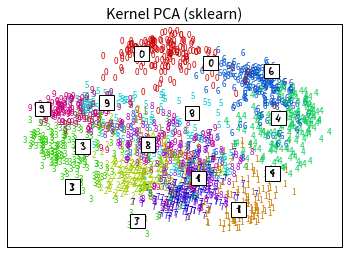

In [16]:
# determine a good gamma for the rbf kernel
D = squareform(pdist(X, 'euclidean'))
gamma = 1./(np.median(D)**2)
# Gaussian kernel PCA
e_gkpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
X_embed = e_gkpca.fit_transform(X)
plot_digits(X_embed, digits, title='Kernel PCA (sklearn)')

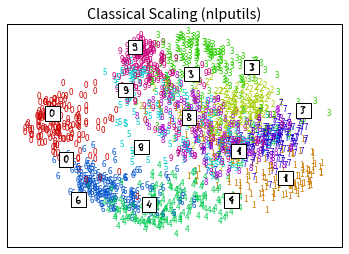

In [17]:
# classical scaling with rbf kernel
K_rbf = rbf_kernel(X, X, gamma)
X_embed = classical_scaling(K_rbf)
plot_digits(X_embed, digits, title='Classical Scaling (nlputils)')

#### t-SNE
The sklearn implementation of t-SNE takes as input the original data and by default computes a similarity matrix for you based on a specified perplexity value and the euclidean distances between the data points. The nlputils t-SNE function on the other hand takes as input a precomputed similarity matrix. To get results comparable to the sklearn implementation, we use the euclidean distance here as well to compute the pairwise distance matrix, which is then transformed into the similarity matrix with the `dist2kernel` function.

Please note that the optimization process of t-SNE is non-convex and the results depend on the random initialization of the coordinates, therefore the solutions of both t-SNE implementations will never quite look the same.

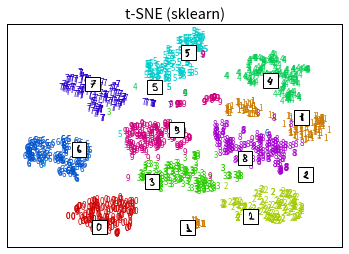

In [18]:
# t-SNE from sklearn (uses the original data and computes the similarity matrix for you)
e_tsne = TSNE(n_components=2, random_state=1, method='exact', perplexity=30)
X_embed = e_tsne.fit_transform(X)
plot_digits(X_embed, digits, title='t-SNE (sklearn)')

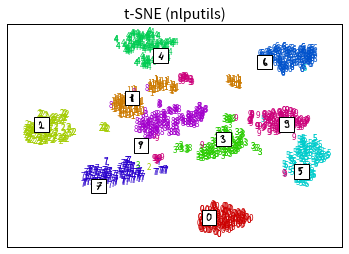

In [19]:
# compute the euclidean distance matrix
D = squareform(pdist(X, 'euclidean'))
# transform it into a similarity matrix with perplexity 30
K_tsne = dist2kernel(D, perp=30)
# embed with t-SNE and plot
X_embed = tsne_sim(K_tsne, verbose=False)
plot_digits(X_embed, digits, title='t-SNE (nlputils)')

### Classify with SVM and knn
Next, we classify the images of the handwritten digits using the SVM classifier from sklearn and the knn classifier from nlputils.

For this we first have to split the data into training and test folds.

In [20]:
# randomly split data into training (80%) and test (20%) folds
np.random.seed(42)
n_test = int(0.2*n_samples)
rnd_idx = np.random.permutation(X.shape[0])
X_test, y_test = X[rnd_idx[:n_test],:], y[rnd_idx[:n_test]]
X, y = X[rnd_idx[n_test:],:], y[rnd_idx[n_test:]]

In [21]:
# classify with rbf SVM (sklearn)
clf = SVC(gamma=gamma, random_state=1)
clf.fit(X, y)
y_pred = list(clf.predict(X_test))
print "Accuracy: %.5f" % skmet.accuracy_score(y_test, y_pred)

Accuracy: 0.98607


In [22]:
# classify with knn (nlputils)
# compute the similarity matrix (we'll also use the rbf kernel here)
K_map = rbf_kernel(X_test, X, gamma)
# construct a doccats dictionary with a list of (single) class labels
doccats_knn = {tid:[c] for tid, c in enumerate(y)}
# for the train and test labels we just use the range of numbers
train_ids = range(len(y))
test_ids = range(len(y), n_samples)
# apply knn to get a score for every document and category, indicating how likely it 
# is that this document belongs to this category.
likely_cat = knn(K_map, train_ids, test_ids, doccats_knn, k=15, adapt=True, alpha=5, weight=True)
# transform the category scores into actual labels for each document
labels = get_labels(likely_cat, threshold='max')
# transform the returned labels dict into a vector and compute the accuracy
y_pred = [labels[tid][0] for tid in test_ids]
print "Accuracy: %.5f" % skmet.accuracy_score(y_test, y_pred)

Accuracy: 0.98050


Classifying handwritten digits is a pretty easy task and when using an rbf kernel as the similarity matrix, the performance achieved with knn is almost as good as with SVM.